In [1]:
import sys
sys.path.append('/home/jxm3/research/deidentification/unsupervised-deidentification')

from datamodule import WikipediaDataModule
from model import AbstractModel, CoordinateAscentModel
from utils import get_profile_embeddings_by_model_key

import argparse
import collections
import glob
import json
import os
import re

import datasets
import pandas as pd
import torch
import transformers
from tqdm import tqdm


from model_cfg import model_paths_dict

datasets.utils.logging.set_verbosity_error()


num_cpus = len(os.sched_getaffinity(0))


def get_profile_embeddings(model_key: str):
    profile_embeddings = get_profile_embeddings_by_model_key(model_key=model_key)

    print("concatenating train, val, and test profile embeddings")
    all_profile_embeddings = torch.cat(
        (profile_embeddings['test'], profile_embeddings['val'], profile_embeddings['train']), dim=0
    )

    print("all_profile_embeddings:", all_profile_embeddings.shape)
    return all_profile_embeddings

def load_adv_csv(dm: WikipediaDataModule, max_num_samples: int = 100) -> pd.DataFrame:
    # Load adv CSVs
    adv_df = None
    adv_csvs_folder = os.path.normpath(
        os.path.join(
            os.getcwd(), os.pardir, 'adv_csvs_full_8'
        )
    )
    print('adv_csvs_folder', adv_csvs_folder)
    model_csv_filenames = list(glob.glob(
        os.path.join(
            adv_csvs_folder,
            'model*/results*.csv'
        )
    ) )
    print("len(model_csv_filenames) =", len(model_csv_filenames))
    for filename in (model_csv_filenames):
        # print('filename:', filename)
        df = pd.read_csv(filename)
        
        if len(df) < 1000: continue
        
        df = df[(df['result_type'] == 'Successful') | (df['result_type'] == 'Skipped')]
        json_filename = filename.replace('.csv', '__args.json')
        assert os.path.exists(json_filename)
        
        adv_csv_json = json.load(open(json_filename, 'r'))
        
        ##### Only take results that are IDF ("nomodel") or from chosen hparam values. ######
        if not (('nomodel' in filename) or (
            (adv_csv_json["table_score"] == 0.1)
            and
            (adv_csv_json["min_percent_words"] == 0.4)
            and
            (adv_csv_json["min_idf_weighting"] == 1.0)
        )):
            continue
        
        df["filename"] = filename
        for key, val in adv_csv_json.items():
            df[key] = val
        df["i"] = df.index
        
        df = df.rename(columns={"model": "model_name"})

        mini_df = df.iloc[:max_num_samples]

        if adv_df is None:
            adv_df = mini_df
        else:
            adv_df = pd.concat((adv_df, mini_df), axis=0)
        # print(adv_df)
    
    print("loaded adv_df of length", len(adv_df))
    # Load baseline redacted data
    mini_test_dataset = dm.test_dataset[:max_num_samples]
    doc_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document']
    )
    doc_df['model_name'] = 'document'
    doc_df['i'] = doc_df.index
    doc_df['filename'] = 'document'
    
    ner_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document_redact_ner_bert']
    )
    ner_df['model_name'] = 'named_entity'
    ner_df['i'] = ner_df.index
    ner_df['filename'] = 'named_entity'
        
    lex_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document_redact_lexical']
    )
    lex_df['model_name'] = 'lexical'
    lex_df['i'] = lex_df.index
    lex_df = lex_df.iloc[:max_num_samples]
    lex_df['filename'] = 'lexical'

    # Combine both adversarial and baseline redacted data
    baseline_df = pd.concat((doc_df, lex_df, ner_df), axis=0)
    for key in adv_csv_json.keys():
        if key not in baseline_df: baseline_df[key] = None
        
    
    full_df = pd.concat((adv_df, baseline_df), axis=0)
    
    # Put newlines back
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('<SPLIT>', '\n'))

    # Standardize mask tokens
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('[MASK]', dm.mask_token))
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('<mask>', dm.mask_token))
    
    # Fair truncation
    full_df['original_num_words'] = full_df['perturbed_text'].map(lambda s: len(s.split()))
    for i in full_df['i'].unique():
        #         df.loc[df.loc[df['a'] == 1,'b'].index[1], 'b'] = 3
        min_num_words = full_df[full_df['i'] == i]['original_num_words'].min()
        full_df.loc[full_df[full_df['i'] == i].index, 'perturbed_text'] = (
            full_df.loc[full_df[full_df['i'] == i].index, 'perturbed_text'].map(
                lambda t: ' '.join(t.split()[:min_num_words])
            )
        )
    
    full_df['num_words'] = full_df['perturbed_text'].map(lambda s: len(s.split()))
    
    
    # This makes sure sure all documents with a given index have the same number of words.
    assert full_df.groupby('i')['num_words'].std().max() == 0.0

    return full_df


def get_adv_predictions(model_key: str, max_num_samples: int):
    checkpoint_path = model_paths_dict[model_key]
    assert isinstance(checkpoint_path, str), f"invalid checkpoint_path {checkpoint_path} for {model_key}"
    print(f"running eval on {model_key} loaded from {checkpoint_path}")
    model = CoordinateAscentModel.load_from_checkpoint(
        checkpoint_path
    )

    print(f"loading data with {num_cpus} CPUs")
    dm = WikipediaDataModule(
        document_model_name_or_path=model.document_model_name_or_path,
        profile_model_name_or_path=model.profile_model_name_or_path,
        dataset_name='wiki_bio',
        dataset_train_split='train[:256]',
        dataset_val_split='val[:256]',
        dataset_test_split='test[:100%]',
        dataset_version='1.2.0',
        num_workers=num_cpus,
        train_batch_size=256,
        eval_batch_size=256,
        max_seq_length=128,
        sample_spans=False,
    )
    dm.setup("fit")

    adv_csv = load_adv_csv(dm=dm, max_num_samples=max_num_samples)

    all_profile_embeddings = get_profile_embeddings(model_key=model_key).cuda()

    model.document_model.eval()
    model.document_model.cuda()
    model.document_embed.eval()
    model.document_embed.cuda()

    topk_values = []
    topk_idxs = []
    true_profile_idxs = []
    batch_size = 256
    i = 0
    pbar = tqdm(total=len(adv_csv), leave=False, desc='Making predictions...')
    while i < len(adv_csv):
        ex = adv_csv.iloc[i:i+batch_size]
        test_batch = dm.document_tokenizer.batch_encode_plus(
            ex['perturbed_text'].tolist(),
            max_length=dm.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        test_batch = {
            f'perturbed_text__{k}': v for k,v in test_batch.items()
        }
        correct_idxs = torch.tensor(ex['i'].tolist()).cuda()
        with torch.no_grad():
            document_embeddings = model.forward_document(batch=test_batch, document_type='perturbed_text')
            document_to_profile_logits = document_embeddings @ all_profile_embeddings.T
            document_to_profile_probs = document_to_profile_logits.softmax(dim=1)
            topk_10 = document_to_profile_probs.topk(10)
            topk_values.append(topk_10.values)
            topk_idxs.append(topk_10.indices)
            
            batch_true_profile_idxs = (
                (document_to_profile_logits.argsort(dim=1).flip(1) == correct_idxs[:, None]).nonzero()[:, 1]
            )
            true_profile_idxs.append(batch_true_profile_idxs)

        i += batch_size
        pbar.update(batch_size)
    
    adv_csv['pred_topk_values'] = torch.cat(topk_values, dim=0).cpu().tolist()
    adv_csv['pred_topk_idxs'] = torch.cat(topk_idxs, dim=0).cpu().tolist()
    adv_csv['true_profile_idxs'] = torch.cat(true_profile_idxs, dim=0).cpu().tolist()
    
    
    model.document_model.cpu()
    model.document_embed.cpu()
    model.cpu()
    return adv_csv



In [2]:
################################ testing code for loading csvs ################################
###   dm = WikipediaDataModule(
###       document_model_name_or_path='roberta-base',
###       profile_model_name_or_path='google/tapas-base',
###       dataset_name='wiki_bio',
###       dataset_train_split='train[:256]',
###       dataset_val_split='val[:256]',
###       dataset_test_split='test[:100%]',
###       dataset_version='1.2.0',
###       num_workers=num_cpus,
###       train_batch_size=256,
###       eval_batch_size=256,
###       max_seq_length=128,
###       sample_spans=False,
###   )
###   dm.setup("fit")
###   adv_csv = load_adv_csv(dm=dm, max_num_samples=100)
################################################################################################

In [3]:
n = 1000

# pmlm_tapas_lex_predictions = get_adv_predictions(model_key='model_3_5__epoch47', max_num_samples=n)
pmlm_tapas_predictions = get_adv_predictions(model_key='model_3_4', max_num_samples=n)
roberta_tapas_predictions = get_adv_predictions(model_key='model_3_2', max_num_samples=n)
roberta_roberta_predictions = get_adv_predictions(model_key='model_3_3', max_num_samples=n)
# TODO: drop predictions if we predicted the same thing with same hparams just different values of n. Like
# if we have filenames with n=1000 and n=100. Just take the one with largest n.

running eval on model_3_4 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__pmlm-a__tapas__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_default/1g8o1iw3_749/checkpoints/epoch=65-step=150281-idf_total.ckpt
Initialized model with learning_rate = 5e-05 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `[MASK]`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 108
loaded adv_df of length 46739
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_4/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_4/val

running eval on model_3_2 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__roberta__tapas__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_lightning_logs/ojgxa1tf_6/checkpoints/epoch=65-step=150282-idf_total.ckpt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 108
loaded adv_df of length 46739
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_2/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_2/val.pkl
>> loaded 72831 test embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_2/test.pkl
concatenating train, val, and test profile embeddings
all_profile_embeddings: torch.Size([728321, 307

running eval on model_3_3 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__roberta__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_lightning_logs/2cr1gp87_28/checkpoints/epoch=68-step=157113.ckpt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaMod

Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 108
loaded adv_df of length 46739
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_3/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_3/val.pkl
>> loaded 72831 test embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_3/test.pkl
concatenating train, val, and test profile embeddings
all_profile_embeddings: torch.Size([728321, 307

In [11]:
new_model_name = {
    'model_3_1': 'roberta_tapas__no_masking',
    'model_3_2': 'roberta_tapas',
    'model_3_3': 'roberta_roberta',
    'model_3_4': 'pmlm_tapas',
    'model_3_5__epoch47': 'pmlm_tapas_lex',
}

preds_by_model_name = {
    # 'roberta_tapas__no_masking': None,
    'roberta_tapas': roberta_tapas_predictions,
    'roberta_roberta': roberta_roberta_predictions,
    'pmlm_tapas': pmlm_tapas_predictions,
    # 'bm25': bm25_predictions,
    # 'pmlm_tapas_lex': pmlm_tapas_lex_predictions,
}

##############################################################################################################

out_df = pmlm_tapas_predictions.rename(
    columns={
        'pred_topk_values': 'pmlm_tapas_pred_topk_values', 
        'pred_topk_idxs': 'pmlm_tapas__pred_topk_idxs',
        'true_profile_idxs': 'pmlm_tapas__true_profile_idxs',
    }
)
out_df['model_name'] = out_df['model_name'].apply(lambda s: new_model_name.get(s, s))

# Only take predictions from the first files outputted. Sometimes they change in-between
# so some dataframes have more than others.
shared_filenames = pmlm_tapas_predictions['filename'].unique()

for model_name, model_df in preds_by_model_name.items():
    print(model_name)
    model_df['was_correct'] = (
        model_df['pred_topk_idxs'].map(lambda L: L[0] if len(L) else None) == model_df['i']
    )
    # Makes sure all the files in this df were in the first one we loaded too. Prevents weird
    # issues where a file pops up in-between loading predictions from different models and we have 
    # dataframes of different lengths.
    model_df_smaller = model_df[model_df['filename'].map(lambda s: s in shared_filenames)].reset_index()
    out_df[f'{model_name}__was_correct'] = (
        # TODO: figure out why we need tolist() here.
        model_df_smaller['was_correct'].tolist()
    )
    print(f'{model_name}__was_correct', out_df[f'{model_name}__was_correct'].mean())
    out_df[f'{model_name}__topk_idxs'] = model_df_smaller['pred_topk_idxs'].tolist()
    out_df[f'{model_name}__topk_values'] = model_df_smaller['pred_topk_values'].tolist()
    if 'true_profile_idxs' in model_df_smaller.columns: out_df[f'{model_name}__true_profile_idxs'] = model_df_smaller['true_profile_idxs'].tolist()
    
out_df['any_model__was_correct'] = (
    out_df['roberta_roberta__was_correct'] | 
    out_df['roberta_tapas__was_correct'] | 
    out_df['pmlm_tapas__was_correct']
    # | out_df['pmlm_tapas_lex__was_correct']
)

out_df['perturbed_text'] = out_df['perturbed_text'].map(lambda s: s.replace('[MASK]', '<mask>'))
out_df['num_masks'] = out_df['perturbed_text'].map(lambda s: s.count('<mask>'))

out_df = out_df.drop(columns=['level_0', 'index', 'Unnamed: 0'], errors='ignore')
out_df.head()

roberta_tapas
roberta_tapas__was_correct 0.28856631617040956
roberta_roberta
roberta_roberta__was_correct 0.3332998250869539
pmlm_tapas
pmlm_tapas__was_correct 0.25177426164579103


,original_person,original_text,perturbed_person,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,...,roberta_tapas__true_profile_idxs,roberta_roberta__was_correct,roberta_roberta__topk_idxs,roberta_roberta__topk_values,roberta_roberta__true_profile_idxs,pmlm_tapas__was_correct,pmlm_tapas__topk_idxs,pmlm_tapas__topk_values,any_model__was_correct,num_masks
0,Lenny randle,"leonard shenoff randle ( born february 12 , 19...",Lenny randle,"<mask> <mask> <mask> ( <mask> <mask> <mask> , ...",-1.0,0.048638,0.0,0.0,0.0,663.0,...,6059,False,"[353670, 572552, 688038, 245341, 151335, 57628...","[0.0018827600870281458, 0.001633231877349317, ...",48412,False,"[213899, 450117, 562361, 459299, 653052, 25746...","[0.032093536108732224, 0.008493590168654919, 0...",False,31
1,Lenny randle,philippe adnot ( born 25 august 1945 in rhèges...,Lenny randle,<mask> <mask> ( <mask> <mask> <mask> <mask> in...,-1.0,0.048638,0.0,0.0,1.0,3398.0,...,889,False,"[30980, 708944, 599078, 364663, 360385, 538169...","[0.026685601100325584, 0.012855439446866512, 0...",206,False,"[253427, 583055, 140849, 555483, 100301, 69467...","[0.003854961832985282, 0.0031959153711795807, ...",False,77
2,Lenny randle,miroslav popov ( born 14 june 1995 in dvůr krá...,Lenny randle,<mask> <mask> ( <mask> <mask> <mask> <mask> in...,-1.0,0.048638,0.0,0.0,2.0,616.0,...,588,False,"[413790, 256174, 627576, 132875, 8198, 363309,...","[0.2667568027973175, 0.03728743642568588, 0.02...",73,False,"[557846, 399336, 460879, 300650, 16985, 218387...","[0.042731475085020065, 0.02043233998119831, 0....",False,30
3,Lenny randle,john `` jack '' reynolds ( 21 february 1869 --...,Lenny randle,<mask> `` <mask> '' <mask> ( <mask> <mask> <ma...,-1.0,0.048638,0.0,0.0,3.0,2477.0,...,162,False,"[560833, 600655, 653717, 58317, 609650, 355924...","[0.012089842930436134, 0.010967615991830826, 0...",504,False,"[417613, 318094, 185910, 708432, 517476, 36241...","[0.0293087437748909, 0.020047971978783607, 0.0...",False,69
4,Lenny randle,"william ato ankrah , ( born 7th july 1979 ) be...",Lenny randle,"<mask> <mask> <mask> , ( <mask> <mask> <mask> ...",-1.0,0.048638,0.0,0.0,4.0,846.0,...,15521,False,"[697077, 689394, 566767, 392198, 216246, 22462...","[0.005693531129509211, 0.0056126001290977, 0.0...",101567,False,"[697077, 541741, 350222, 498841, 64669, 215915...","[0.011341960169374943, 0.006159963086247444, 0...",False,38


In [12]:
(out_df[(out_df['filename'] == 'document')]['roberta_roberta__true_profile_idxs'] == 0).mean()

0.991

In [13]:
out_df[(out_df['filename'] == 'document')]['roberta_roberta__was_correct'].mean()

0.991

In [14]:
import seaborn as sns

sns.set()
sns.set_theme(context="paper", style="white")

In [20]:
out_df["filename"].unique()

array(['/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts100.0__nomodel__idf0.0__mp1.0__k_0__n_1000__type_swap.csv',
       '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts100.0__nomodel__idf0.0__mp1.0__mig12.0__epsNone__k_0__n_1000__type_swap.csv',
       '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts100.0__nomodel__idf0.0__mp1.0__mig6.0__epsNone__k_0__n_1000__type_swap.csv',
       '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts100.0__nomodel__idf0.0__mp1.0__mig11.0__epsNone__k_0__n_1000__type_swap.csv',
       '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts100.0__nomodel__idf0.0__mp1.0__mig10.0__epsNone__k_0__n_1000__type_swap.csv',
       '/home/jxm3/research/deidentification

In [21]:
from typing import Any, Dict

def get_group_name(row: Dict[str, Any]) -> str:
    filename = row['filename']
    if filename in ['document', 'lexical', 'named_entity']:
        return filename
    elif "nomodel" in filename:
        if "_ts100.0_" in filename:
            return "IDF (table-aware)"
        else:
            return "IDF"
    else:
        return "NN"
        # return f"ts_{row['table_score']:.2f}__mpw{row['min_percent_words']:.2f}__min_idf{row['min_idf_weighting']:.2f}"
    out_df["group_name"] = out_df.apply(get_group_name, axis=1)
    

# have to fill NaNs with 0.0 so we can keep those columns. this also drops results from some other experiments that i had b=2.
df_grouped = out_df.fillna(0.0)[out_df.fillna(0.0)["beam_width"] <= 1].groupby("filename").mean().reset_index()

df_grouped["percent_masks"] = df_grouped["num_masks"] / df_grouped["num_words"]
df_grouped["percent_not_masks"] = 1.0 - df_grouped["percent_masks"]

print("% masks:", df_grouped["percent_masks"].mean())
    
df_grouped["group_name"] = df_grouped.apply(lambda row: get_group_name(row), axis=1)
# df_grouped["filename_short"] = df_grouped["filename"].map(lambda s: s[s.rindex('/')+1:s.rindex('.csv')] if '.csv' in s else s) # TODO renamee
# df_grouped["model_name__k"] = df_grouped["model_name"] + df_grouped["k"].map(lambda k: f'__{k}')

# https://matplotlib.org/stable/api/markers_api.html
marker_by_model_name = {
    "lexical": "s", #"X",
    "named_entity": "s", # "X",
    "document": "s"
}
df_grouped["marker"] = df_grouped.apply(lambda row: marker_by_model_name.get(row["group_name"], "o"), axis=1)

num_filenames = len(df_grouped["group_name"].unique())
color_by_model_name = dict(
    zip(df_grouped["group_name"].unique(), sns.color_palette("hls", num_filenames))
)
df_grouped["color"] = df_grouped["group_name"].apply(color_by_model_name.get)

% masks: 0.29742050614445054


In [22]:
df_grouped.groupby("group_name").mean()["any_model__was_correct"]

group_name
IDF                  0.959143
IDF (table-aware)    0.245536
NN                   0.239508
document             0.996000
lexical              0.319000
named_entity         0.797000
Name: any_model__was_correct, dtype: float64

In [88]:
sorted(df_grouped["eps"].unique().tolist())

[0.0,
 1e-08,
 1e-07,
 1e-06,
 2e-06,
 5e-06,
 1e-05,
 2e-05,
 5e-05,
 0.0001,
 0.0005,
 0.001,
 0.005,
 0.01,
 0.02,
 0.05,
 0.1,
 0.2,
 0.5,
 0.7]

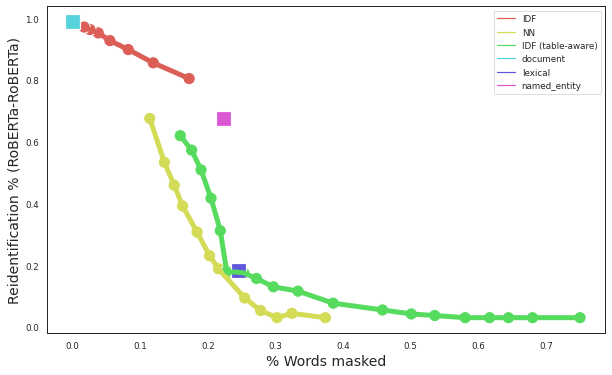

In [101]:
import matplotlib.pyplot as plt

def make_reid_plot(reid_model_name: str, x_column: str, xlabel: str, ylabel: str, marker_size: int = 150, set_lim=True):
    plt.figure(figsize=(10,6))
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    group_key = "group_name"
    
    # df_grouped_filtered = df_grouped
    df_grouped_filtered = df_grouped[
        df_grouped[group_key].apply(lambda row_model_name: (reid_model_name not in row_model_name))
    ]
    
    def should_we_keep_this_line(row: str) -> bool:
        group_name = row["group_name"]
        if group_name == "NN":
            # filter out most points since we have way too many data points too close together
            eps_values_for_graph = [
                1e-08, 1e-07, 1e-06, 1e-4, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.7
            ]
            eps = row["eps"]
            return eps in eps_values_for_graph
        elif group_name == "IDF (table-aware)":
            # filter out runs that had min percent words of less than 0.5
            # because they make IDF look unnecessarily bad when aggregated.
            mpw = row["min_percent_words"]
            return mpw >= 0.5
        else:
            return True
    # print(df_grouped_filtered)
    y_column = f"{reid_model_name}__was_correct"
    
    df_grouped_filtered = df_grouped[df_grouped.apply(should_we_keep_this_line, axis=1)].reset_index()
    df_grouped_filtered[y_column]= df_grouped_filtered[y_column].clip(lower=0.03) 
    
    g1 = sns.lineplot(
        data=df_grouped_filtered,
        x=x_column,
        y=y_column,
        hue=group_key,
        palette=color_by_model_name,
        linewidth=5,
        legend=True
    )
    # g1.set_xscale('log')
    g1.legend(loc='upper right')
    if set_lim: g1.set(xlim=(.18,.8), ylim=(-0.05, 0.45))
    for marker_type in df_grouped["marker"].unique():
        df_grouped_marker = df_grouped_filtered[
            df_grouped_filtered["marker"] == marker_type
        ]
        g2 = sns.scatterplot(
            data=df_grouped_marker,
            x=x_column,
            y=y_column,
            hue=group_key,
            palette=color_by_model_name,
            s=(marker_size if marker_type == 'o' else marker_size*1.5),
            marker=marker_type,
            legend=False
        )
        # g2.set_xscale('log')
    if set_lim: g2.set(xlim=(.18,.8), ylim=(-0.05, 0.45))


make_reid_plot(reid_model_name="roberta_roberta", x_column="percent_masks", ylabel="Reidentification % (RoBERTa-RoBERTa)", xlabel="% Words masked", set_lim=False)

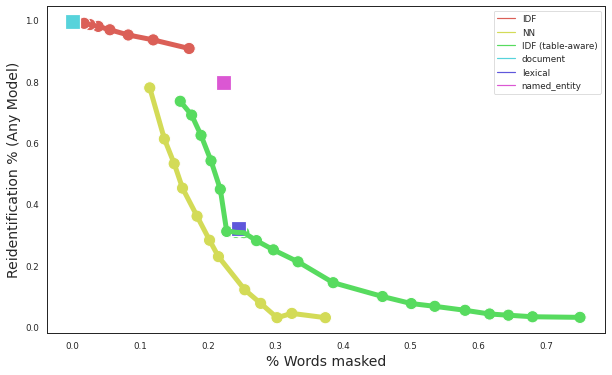

In [104]:
make_reid_plot(reid_model_name="any_model", x_column="percent_masks", ylabel="Reidentification % (Any Model)", xlabel="% Words masked", set_lim=False)

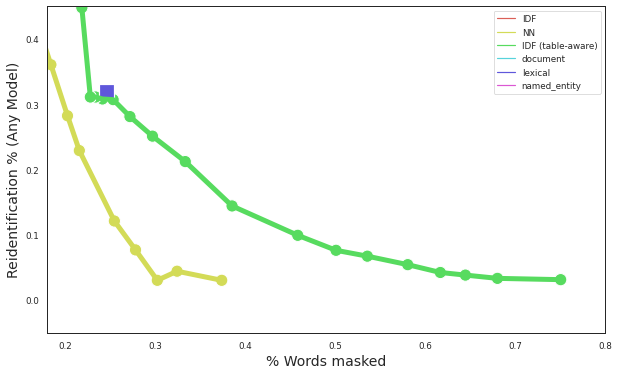

In [103]:
make_reid_plot(reid_model_name="any_model", x_column="percent_masks", ylabel="Reidentification % (Any Model)", xlabel="% Words masked", set_lim=True)

In [79]:
best_idf_filename

'/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts100.0__nomodel__idf0.0__mp1.0__mig0.5__epsNone__k_0__n_1000__type_swap.csv'

In [84]:
df_grouped[df_grouped["group_name"].map(lambda s: "NN" in s)].sort_values(by='any_model__was_correct')

,filename,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,min_percent_words,k,eps,...,roberta_roberta__was_correct,roberta_roberta__true_profile_idxs,pmlm_tapas__was_correct,any_model__was_correct,num_masks,percent_masks,percent_not_masks,group_name,marker,color
21,/home/jxm3/research/deidentification/unsupervi...,-13.711178,1.000000,5100.851852,63978.444444,523.259259,676.888889,0.4,0.0,1.000000e-08,...,0.000000,26831.222222,0.000000,0.000000,27.888889,0.373697,0.626303,NN,o,"(0.8287999999999999, 0.86, 0.33999999999999997)"
23,/home/jxm3/research/deidentification/unsupervi...,-15.252450,1.005602,2163.844828,77464.474138,481.250000,576.922414,0.4,0.0,2.000000e-06,...,0.021552,11328.939655,0.000000,0.025862,21.961207,0.299882,0.700118,NN,o,"(0.8287999999999999, 0.86, 0.33999999999999997)"
19,/home/jxm3/research/deidentification/unsupervi...,-15.072487,1.005208,2500.567708,74405.151042,467.432292,581.984375,0.4,0.0,1.000000e-06,...,0.020833,12019.942708,0.000000,0.026042,22.229167,0.302159,0.697841,NN,o,"(0.8287999999999999, 0.86, 0.33999999999999997)"
25,/home/jxm3/research/deidentification/unsupervi...,-15.472058,1.007115,1811.525424,74727.233898,488.264407,547.772881,0.4,0.0,5.000000e-06,...,0.020339,9016.332203,0.000000,0.027119,21.203390,0.295340,0.704660,NN,o,"(0.8287999999999999, 0.86, 0.33999999999999997)"
18,/home/jxm3/research/deidentification/unsupervi...,-15.540369,1.010913,1967.543103,71815.189655,488.465517,506.063218,0.4,0.0,1.000000e-05,...,0.034483,6858.086207,0.000000,0.040230,19.982759,0.288572,0.711428,NN,o,"(0.8287999999999999, 0.86, 0.33999999999999997)"
20,/home/jxm3/research/deidentification/unsupervi...,-14.493810,1.002198,2669.439560,73320.186813,449.252747,599.329670,0.4,0.0,1.000000e-07,...,0.043956,19000.098901,0.000000,0.043956,23.780220,0.324098,0.675902,NN,o,"(0.8287999999999999, 0.86, 0.33999999999999997)"
22,/home/jxm3/research/deidentification/unsupervi...,-15.689980,1.012550,1787.939698,72489.505025,494.675879,492.216080,0.4,0.0,2.000000e-05,...,0.040201,5855.080402,0.000000,0.052764,19.542714,0.285494,0.714506,NN,o,"(0.8287999999999999, 0.86, 0.33999999999999997)"
24,/home/jxm3/research/deidentification/unsupervi...,-15.886028,1.016043,1571.031315,74892.208768,496.461378,464.949896,0.4,0.0,5.000000e-05,...,0.050104,5085.722338,0.000000,0.070981,18.726514,0.280111,0.719889,NN,o,"(0.8287999999999999, 0.86, 0.33999999999999997)"
7,/home/jxm3/research/deidentification/unsupervi...,-15.989816,1.019464,1435.624088,76496.939781,496.355839,440.131387,0.4,0.0,1.000000e-04,...,0.052920,3757.591241,0.000000,0.076642,18.102190,0.277941,0.722059,NN,o,"(0.8287999999999999, 0.86, 0.33999999999999997)"
8,/home/jxm3/research/deidentification/unsupervi...,-16.170437,1.021129,1240.597685,74456.547033,495.707670,401.026049,0.4,0.0,5.000000e-04,...,0.070912,1952.752533,0.000000,0.101302,16.641100,0.262157,0.737843,NN,o,"(0.8287999999999999, 0.86, 0.33999999999999997)"


In [105]:
best_idf_filename = df_grouped[df_grouped["group_name"].map(lambda s: "IDF" in s)].sort_values(by='any_model__was_correct')["filename"].tolist()[0]
still_correct_examples = out_df[(out_df['filename'] == best_idf_filename) & out_df['any_model__was_correct']]['perturbed_text'].tolist()
# df_grouped[df_grouped["filename"] == best_idf_filename]["any_model__was_correct"]
still_correct_examples

['<mask> <mask> ( <mask> : <mask>ु<mask>ी<mask> <mask>ो<mask>ा<mask>ा ) ( <mask> <mask> <mask> <mask> ) <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> , <mask> . <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> . <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> . <mask> <mask> <mask> <mask> <mask> in <mask> and <mask> in <mask> <mask> <mask> <mask> <mask> <mask> <mask> in <mask>',
 "<mask> <mask> `` <mask> '' <mask> ( <mask> <mask> <mask> <mask> ) <mask> <mask> <mask> <mask> <mask> , <mask> <mask> , <mask> , <mask> <mask> and <mask> <mask> <mask> <mask> <mask> <mask> <mask> . <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> , <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> . <mask> <mask> <mask>-<mask> in <mask> and in <mask> . 

## outputting data for analysis

In [ ]:
important_filenames = [
    # IDF-weighted, 29.7% masked, 25.1% reidentifiable
    '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts100.0__nomodel__idf0.0__mp1.0__mig7.0__epsNone__k_0__n_1000__type_swap.csv',
    # Deidentified by our model, 23. masked, 12% re-identifiable
    '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts0.1__idf1.0__mp0.4__eps0.001__k_None__n_1000__type_swap.csv',
    # documents: 0% masked, 99.6% identifiable
     'document',
    # lexically-redacted: 24.5% masked, 31.9% identifiable
     'lexical',
    # named-entity-redacted: 22.2% masked, 79.7% identifiable
     'named_entity',
]

In [ ]:
out_df["filename"].unique()

In [ ]:
out_df.columns

In [ ]:
keep_columns = [
    'perturbed_text',
    'num_queries',
    'num_words', 'i',

    'pmlm_tapas__was_correct', 'pmlm_tapas__topk_idxs',
    'pmlm_tapas__topk_values',  'pmlm_tapas__true_profile_idxs',
    
    'roberta_tapas__was_correct', 'roberta_tapas__topk_idxs',
    'roberta_tapas__topk_values', 'roberta_tapas__true_profile_idxs',
    
    'roberta_roberta__was_correct', 'roberta_roberta__topk_idxs',
    'roberta_roberta__topk_values', 'roberta_roberta__true_profile_idxs',

    'any_model__was_correct', 'num_masks',
    'group_name'
]
analysis_df = out_df[out_df["filename"].map(lambda s: s in important_filenames)][keep_columns]
analysis_df["group_name"] = analysis_df["group_name"].replace({"ts_1.0__mpw0.95__min_idf1.0": "pmlm_tapas__eps_0.0005", "IDF": "idf__maxidf_7.0"})
final_analysis_df = analysis_df.rename(columns={"group_name": "deid_method"})

final_analysis_df.to_parquet('../wikibio_redacted_3.parquet.gzip', compression='gzip')

In [ ]:
final_analysis_df["deid_method"].value_counts()


In [ ]:
final_analysis_df[(final_analysis_df["i"] == 0)]

In [ ]:
final_analysis_df[final_analysis_df['deid_method'] == 'lexical']